<center><h2><b>Covid19 Vaccination Progress</b></h2></center>

<center><b>In following notebook I tried to present vaccination progress in terms of continents with plotnine.</b></center> 

# **My Observations:**

1. In top 20 countries with highest total vaccinations - 
    * **7 Asian**, **7 European**, **3 North American**, **2 South American**, **1 African countries**.
2. In top 50 countries with highest total vaccinations - 
    * **23 European**, **13 Asian**, **7 South American**, **5 North America**, **2 African countries**.   
3. In countries with least fully vaccinated people per hundred we have -
    * **Sierra Leone** in Africa - **0.00%**
    * **Ukrain** in Europe - **0.00%**
    * **Mynmar** in Asia - **0.07%**
    * **Guatemala** in North America - **0.01%**
    * **Paraguay** in South America - **0.04%**
   

# **Contents:**
Following plots are shown in this notebook using plotnine python package.
1. **Percentage yet to be vaccinated to achieve herd immunity in select countries USA, China, Brazil, India, UK.**
2. **Daily Vaccination progress in top nations from each continent.**
3. **Top 20 Countries Based on Total Vaccinations**
4. **Top 20 Countries Based on People Vacccinated**
5. **Top 20 Countries Based on People Fully Vacccinated - Stacked with Population**
6. **Top 20 Vaccinated Countries Based on People Fully Vacccinated Per Hundred**
7. **Total Number of Vaccinations for each Vaccine**
8. **Continent wise Count of Countries with Top 50 Most People Fully Vacccinated**
9. **Country with Least Fully Vacccinated People Per Hundred in each Continent**

In [1]:
!pip install pycountry-convert

     |████████████████████████████████| 242 kB 811 kB/s 


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from pandas.api.types import CategoricalDtype
from plotnine import *
from plotnine.data import mpg
from plotnine import options as op
from plotnine import watermark as wm
import matplotlib.pyplot as plt
from PIL import Image
import missingno as msno
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import pycountry_convert as pc
import warnings
warnings.filterwarnings('ignore')
import collections

In [3]:
vaccination_data = pd.read_csv('/kaggle/input/covid-world-vaccination-progress/country_vaccinations.csv')
population_data = pd.read_csv('../input/population-by-country-2020/population_by_country_2020.csv')
vaccination_data.columns

Index(['country', 'iso_code', 'date', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated',
       'daily_vaccinations_raw', 'daily_vaccinations',
       'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'daily_vaccinations_per_million',
       'vaccines', 'source_name', 'source_website'],
      dtype='object')

In [4]:
rename_country = ["England" , "Wales" , "Scotland" , "Northern Ireland"]

for i in rename_country:
     vaccination_data["country"] = vaccination_data["country"].str.replace(i , "United Kingdom")

In [5]:
def convert_df_with_continent(df):
    
    df['continent'] = ['']*df.shape[0]
    
    def continent_name_convert(name):
        if name == 'AF':
            return 'Africa'
        elif name == 'EU':
            return 'Europe'
        elif name == 'NA':
            return 'NA'
        elif name == 'SA':
            return 'SA'
        elif name == 'OC':
            return 'Oceania'
        elif name == 'AS':
            return 'Asia'

    for i in range(df.shape[0]):
        country = df['country'].iloc[i]
        try:
            country_code = pc.country_name_to_country_alpha2(country, cn_name_format="default")
            continent_name = pc.country_alpha2_to_continent_code(country_code)
            continent_name_full = continent_name_convert(continent_name)
            df['continent'].iloc[i] = continent_name_full
    #         print(f'{country} - {continent_name}')
        except:
            if country == "Cote d'Ivoire":
                continent_name = 'AF'
                continent_name_full = continent_name_convert(continent_name)
                df['continent'].iloc[i] = continent_name_full
            elif country == 'Faeroe Islands':
                continent_name = 'EU'
                continent_name_full = continent_name_convert(continent_name)
                df['continent'].iloc[i] = continent_name_full
            elif country == 'Kosovo':
                continent_name = 'EU'
                continent_name_full = continent_name_convert(continent_name)
                df['continent'].iloc[i] = continent_name_full
            elif country == 'Saint Helena':
                continent_name = 'AF'
                continent_name_full = continent_name_convert(continent_name)
                df['continent'].iloc[i] = continent_name_full
            elif country == 'Curacao':
                continent_name = 'SA'
                continent_name_full = continent_name_convert(continent_name)  
                df['continent'].iloc[i] = continent_name_full
            elif country == 'Timor':
                continent_name = 'AS'
                continent_name_full = continent_name_convert(continent_name)
                df['continent'].iloc[i] = continent_name_full
            else:
                print(f'{country} mistake detected')
        continue
    return df



In [6]:
def population_agg(df):
    df['population'] = ['']*df.shape[0]
    for i in range(df.shape[0]):
        country = df['country'].iloc[i]
        try:
            population = population_data.loc[population_data['Country (or dependency)'] == country]['Population (2020)'].values[0]
            df['population'].iloc[i] = population
        except Exception as e:
            df['population'].iloc[i] = np.nan
            continue
    return df

In [7]:
def stack_population_df_fully_vaccinated(df):
    df_new = pd.DataFrame(columns=['country','vaccination_status','total_vaccinations'])
    df_new['country'] = ['']*2*df.shape[0]
    df_new['vaccination_status'] = ['']*2*df.shape[0]
    df_new['total_vaccinations'] = ['']*2*df.shape[0]
    index = 0
    for i in range(df.shape[0]):
        df_new.iloc[index] = [df['country'].iloc[i],'vaccinated',df['people_fully_vaccinated'].iloc[i]]
        df_new.iloc[index+1] = [df['country'].iloc[i],'not_vaccinated',int(df['population'].iloc[i])-int(df['people_fully_vaccinated'].iloc[i])]
        index += 2
    return df_new

In [8]:
def format_number(number):
    return ("{:,}".format(number))

# **Percentage of Vaccination yet to be done to achieve Herd Immunity**

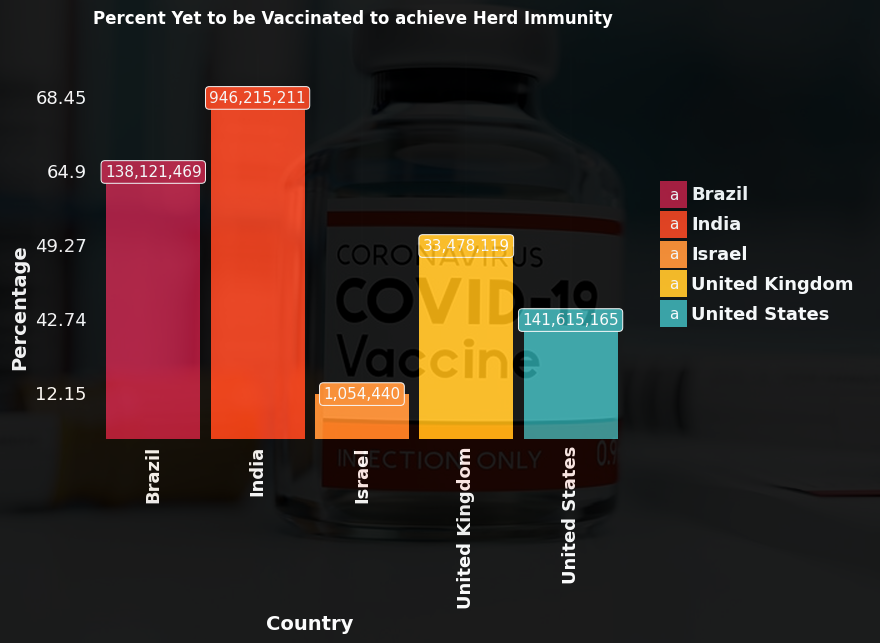

In [9]:
countries_list = ['United States','United Kingdom','India',"Israel",'Brazil']
herd_immunity = pd.DataFrame()
for i in range(vaccination_data.shape[0]):
    if vaccination_data['country'].iloc[i] in countries_list:
        herd_immunity = herd_immunity.append(vaccination_data.iloc[i])
        
herd_immunity_df = pd.DataFrame(herd_immunity.groupby('country')['people_fully_vaccinated_per_hundred'].max())
herd_immunity_df['herd_immune_percent'] = ['']*herd_immunity_df.shape[0] 
for i in range(herd_immunity_df.shape[0]):
    herd_immunity_df['herd_immune_percent'].iloc[i] = round(70 - herd_immunity_df['people_fully_vaccinated_per_hundred'].iloc[i],2)
herd_immunity_df = herd_immunity_df.reset_index()
herd_immunity_df = population_agg(herd_immunity_df)
for i in range(herd_immunity_df.shape[0]):
    herd_immunity_df['population'].iloc[i] = format_number(round(herd_immunity_df['population'].iloc[i] * (herd_immunity_df['herd_immune_percent'].iloc[i]/100)))
    
op.figure_size=(7,5)
ax = (ggplot(herd_immunity_df)         
 + aes(x='country', y='herd_immune_percent',fill='country')    
 + geom_col(size=15)
 + geom_label(aes(label = 'population'),color = "white",label_padding= 0.25,size=11)
 + scale_fill_manual(values = ["#B21236","#F03812","#FE8826","#FEB914","#2C9FA2","#002C2B","#F7E1C0"])
 + labs(title = "Percent Yet to be Vaccinated to achieve Herd Immunity")
 + labs(y = "Percentage", x = "Country")
 + theme(
    panel_background = element_rect(fill = "black"),    
    plot_background = element_rect(fill = "black", color = "black"),
    legend_background = element_rect(fill = "black"),
    legend_key = element_blank(),
   
    panel_grid = element_line(size = 0.01),
    panel_grid_minor_y = element_blank(),
    panel_grid_major_y = element_blank(),
    
    legend_text = element_text(color = "white", size=13,face='bold'),
    axis_text_x = element_text(color = "white", size = 13,angle=90,face='bold'),
    axis_text_y = element_text(color = "white", size = 13, hjust = 1, margin={'b': 20, 't':10}),
    axis_title = element_text(color = "white", size = 14, hjust = 1,face = "bold"),
    plot_title = element_text(color = "white", face = "bold", size = 12, hjust = 4, margin={'b': 20, 't':10}),
    panel_spacing_x = 1
  )
)

fig = ax.draw()

image = plt.imread('https://raw.githubusercontent.com/vineethbabu/coronavaccine_images/main/16_1.png')

fig.figimage(image, xo=0, yo=0, alpha=0.12, norm=None, cmap=None, vmin=None, vmax=None, origin=None, resize=False)

fig.show()

Herd Immunity is said to be achieved when **70-75%** of population is vaccinated. Here I wanted to visualise how much percentage of population is yet to be vaccinated to achieve that target and what in absolute value that would mean in terms of population of that country.

I have select five countries United States, United Kingdom, Brazil, India, Israel

> 1. **India** has to vaccinate **68%** more of its population with **Brazil** closely following India with **65%** more to be vaccinated.
> 2. **USA** and **UK** have to vaccinated roughly **42-50%** more of its population.
> 3. **Israel** on the other hand has to vaccinate only around **10-12%** more to achieve herd immunity.

# **Daily Vaccination Progress In Top Nations From Each Continent**

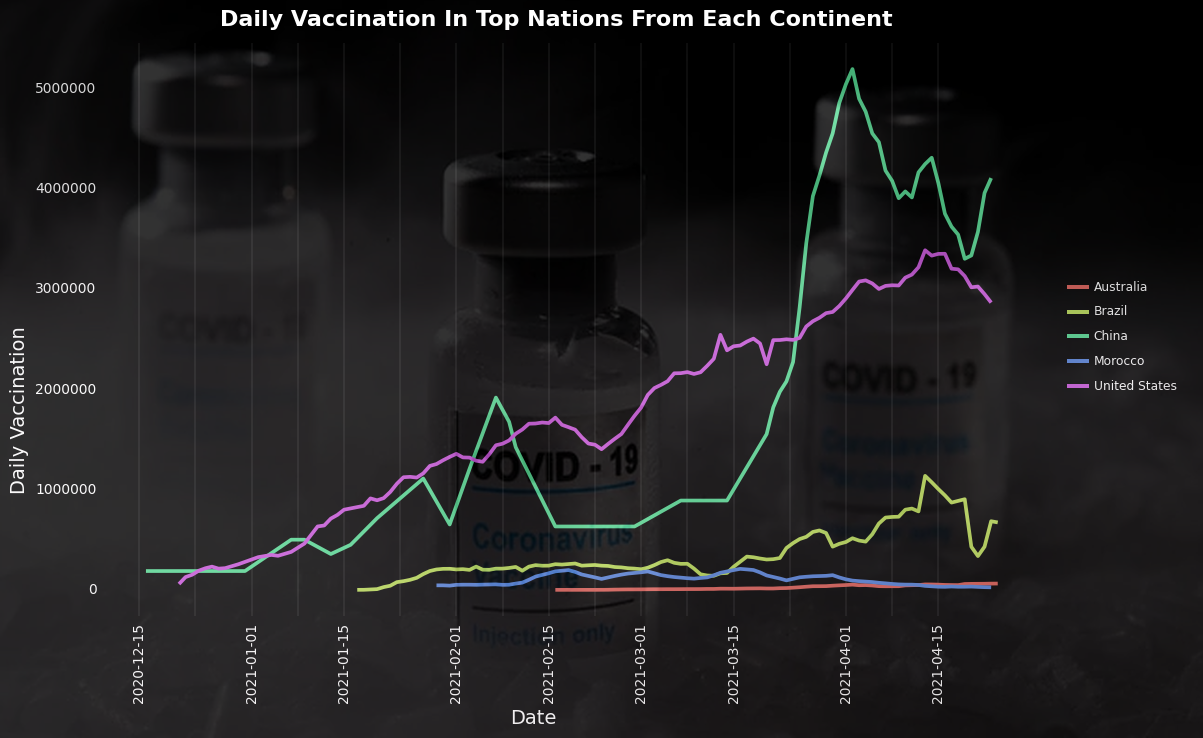

In [10]:
vaccination_data = convert_df_with_continent(vaccination_data)
daily_vaccinations = vaccination_data[['country','total_vaccinations','continent']]
daily_vaccine_df = pd.DataFrame(daily_vaccinations.groupby('continent')['total_vaccinations'].max().sort_values(ascending = False))
daily_vaccine_df = daily_vaccine_df.reset_index()
daily_vaccine_df_continent = pd.DataFrame(columns=['country','date','daily_vaccinations'])
for i in range(daily_vaccine_df.shape[0]):
    df = vaccination_data[(vaccination_data.continent==daily_vaccine_df['continent'].iloc[i]) & (vaccination_data.total_vaccinations==daily_vaccine_df['total_vaccinations'].iloc[i])]
    if df['country'].iloc[0] != 'United Kingdom':
        daily_vaccine_df_continent = daily_vaccine_df_continent.append(vaccination_data[(vaccination_data.country==df['country'].iloc[0])])
daily_vaccine_df_continent = daily_vaccine_df_continent[['country','date','daily_vaccinations']]
daily_vaccine_df_continent = daily_vaccine_df_continent.dropna(how='any',axis=0)
daily_vaccine_df_continent['date']= pd.to_datetime(daily_vaccine_df_continent['date'])
daily_vaccine_df_continent['daily_vaccinations'] = daily_vaccine_df_continent['daily_vaccinations'].astype(int)
op.figure_size=(12, 12)
p = (ggplot(daily_vaccine_df_continent)         
 + aes(y='daily_vaccinations', x='date',color='country')    
 + geom_line(size=1.5) 
 + scale_fill_manual(values = ["#B21236","#723240","#FE8826","#FEB914","#2C9FA2","#002C2B"])
#  + facet_wrap('country')
 + labs(title = "Daily Vaccination In Top Nations From Each Continent")
 + labs(y = "Daily Vaccination", x = "Date")
 + theme(
    panel_background = element_rect(fill = "black"),    
    plot_background = element_rect(fill = "black", color = "black"),
    legend_background = element_rect(fill = "black"),
    legend_key = element_blank(),
   
    panel_grid = element_line(size = 0.1),
    panel_grid_minor_y = element_blank(),
    panel_grid_major_y = element_blank(),
    
    legend_text = element_text(color = "white"),
    axis_text_x = element_text(color = "white", size = 10,angle=90),
    axis_text_y = element_text(color = "white", size = 10),
    axis_title = element_text(color = "white", size = 14, hjust = 1),
    plot_title = element_text(color = "white", face = "bold", size = 16, hjust = 4, margin={'b': 20, 't':10}),
    panel_spacing_x = 1
  )
)

fig = p.draw()

image = plt.imread('https://raw.githubusercontent.com/vineethbabu/coronavaccine_images/main/14_1.png')

fig.figimage(image, xo=0, yo=0, alpha=0.2, norm=None, cmap=None, vmin=None, vmax=None, origin=None, resize=True)

fig.show()

A comparison of daily vaccinations from top nations by total vaccination count from each continent.Here we can see how US and China compare in terms of daily vaccinations.

# **Top 20 Vaccinated Countries by Total Vaccinations**

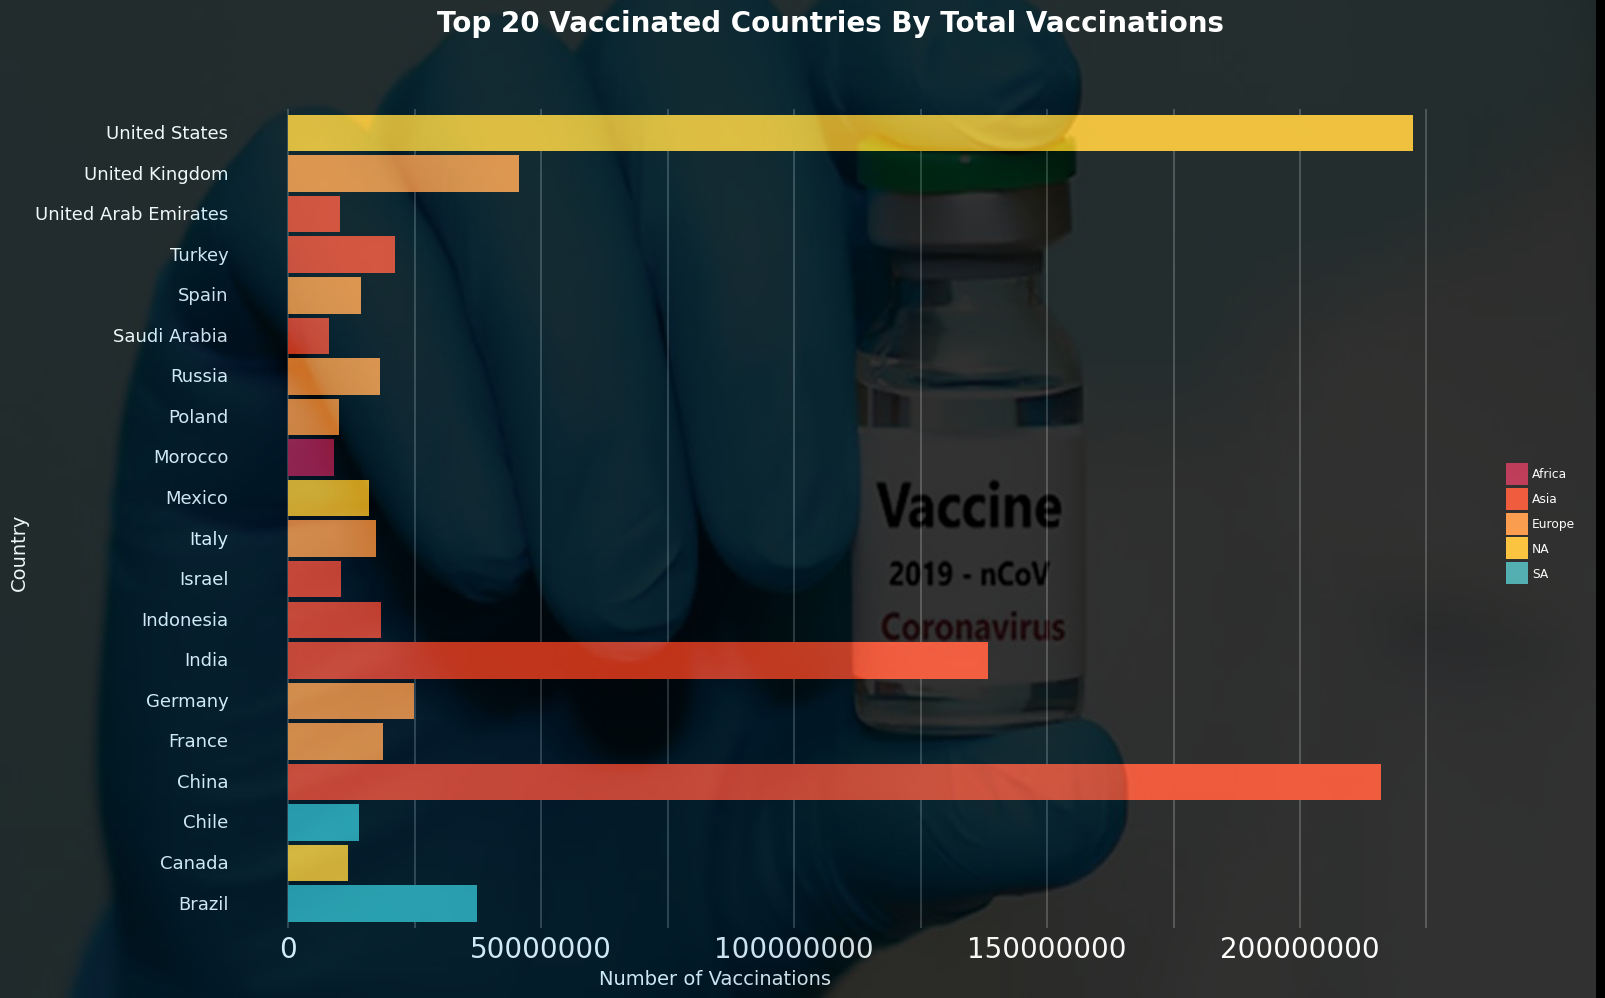

In [11]:
top_20_countries_vaccinated = pd.DataFrame(vaccination_data.groupby("country")["total_vaccinations"].max().sort_values(ascending = False).head(20))
top_20_countries_vaccinated.reset_index(level=0,inplace=True)
top_20_countries_vaccinated = convert_df_with_continent(top_20_countries_vaccinated)
top_20_countries_vaccinated['number_labels'] = ['']*top_20_countries_vaccinated.shape[0]

for i in range(top_20_countries_vaccinated.shape[0]):
    top_20_countries_vaccinated['number_labels'].iloc[i] = format_number(top_20_countries_vaccinated['total_vaccinations'].iloc[i])
    
op.figure_size=(8,5)
ax = (ggplot(top_20_countries_vaccinated)         
 + aes(x='country', y='total_vaccinations',fill='continent')    
 + geom_col(size=20)
#  + geom_label(aes(label = 'number_labels'),ha='right',color = "white",label_padding= 0.25)
 + coord_flip()
 + scale_fill_manual(values = ["#B21236","#F03812","#FE8826","#FEB914","#2C9FA2","#002C2B","#F7E1C0"])
 + labs(title = "Top 20 Vaccinated Countries By Total Vaccinations")
 + labs(y = "Number of Vaccinations", x = "Country")
 + theme(
    panel_background = element_rect(fill = "black"),    
    plot_background = element_rect(fill = "black", color = "black"),
    legend_background = element_rect(fill = "black"),
    legend_key = element_blank(),
   
    panel_grid = element_line(size = 0.3),
    panel_grid_minor_y = element_blank(),
    panel_grid_major_y = element_blank(),
    
    legend_text = element_text(color = "white"),
    axis_text_x = element_text(color = "white", size = 20),
    axis_text_y = element_text(color = "white", size = 13, hjust = 1, margin={'b': 20, 't':10}),
    axis_title = element_text(color = "white", size = 14, hjust = 1),
    plot_title = element_text(color = "white", face = "bold", size = 20, hjust = 4, margin={'b': 20, 't':10}),
    panel_spacing_x = 1
  )
)

fig = ax.draw()

image = plt.imread('https://raw.githubusercontent.com/vineethbabu/coronavaccine_images/main/1_enlargev3.png')

fig.figimage(image, xo=0, yo=0, alpha=0.2, norm=None, cmap=None, vmin=None, vmax=None, origin=None, resize=True)

fig.show()

USA has the most total vaccinations count followed by China, India, UK. Here we have7 Asian, 7 European, 3 North American, 2 South American, 1 Afriacn countries.

# **Top 20 Countries Based on People Vaccinated**

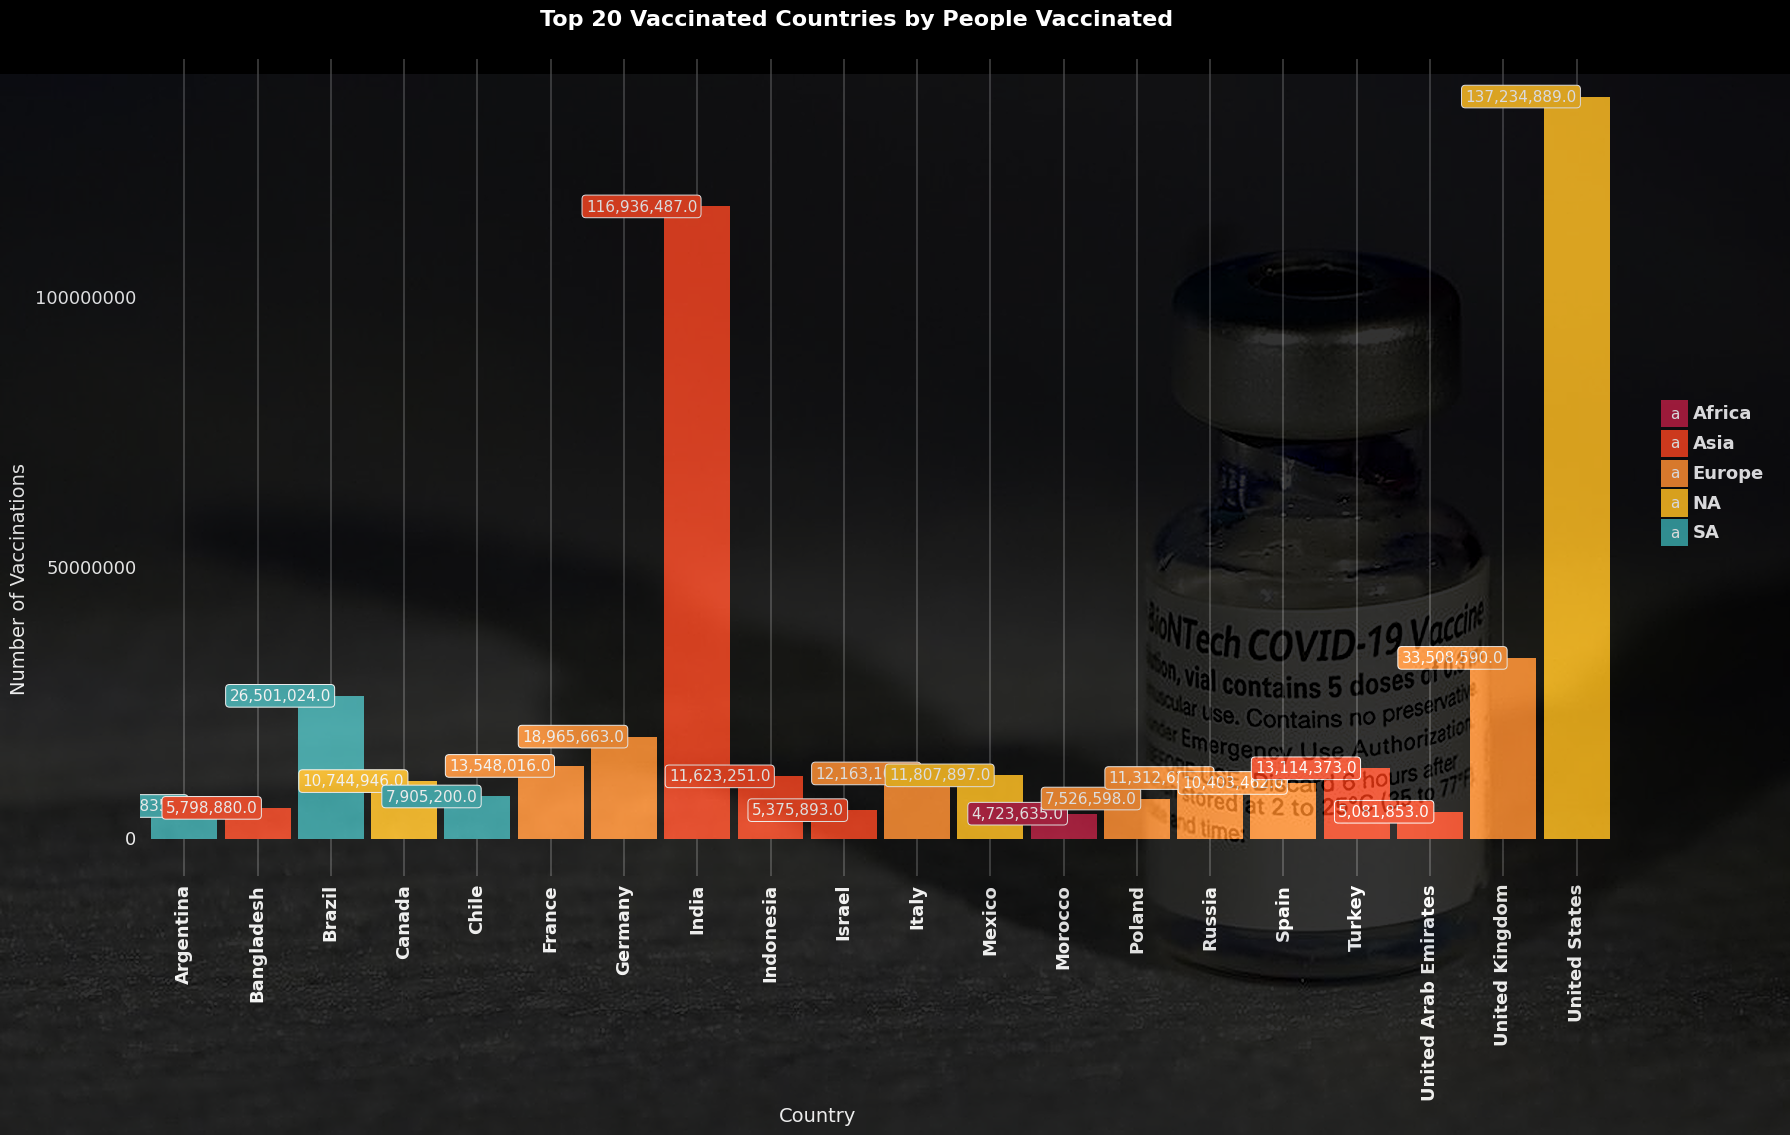

In [12]:
top_20_countries_people_vaccinated = pd.DataFrame(vaccination_data.groupby("country")["people_vaccinated"].max().sort_values(ascending = False).head(20))
top_20_countries_people_vaccinated.reset_index(level=0,inplace=True)
top_20_countries_people_vaccinated = convert_df_with_continent(top_20_countries_people_vaccinated)
top_20_countries_people_vaccinated['number_labels'] = ['']*top_20_countries_people_vaccinated.shape[0]

for i in range(top_20_countries_people_vaccinated.shape[0]):
    top_20_countries_people_vaccinated['number_labels'].iloc[i] = format_number(top_20_countries_people_vaccinated['people_vaccinated'].iloc[i])
    
op.figure_size=(8,10)
ax = (ggplot(top_20_countries_people_vaccinated)         
 + aes(x='country', y='people_vaccinated',fill='continent')    
 + geom_col(size=15)
 + geom_label(aes(label = 'number_labels'),ha='right',color = "white",label_padding= 0.25,size=11)
 + scale_fill_manual(values = ["#B21236","#F03812","#FE8826","#FEB914","#2C9FA2","#002C2B","#F7E1C0"])
 + labs(title = "Top 20 Vaccinated Countries by People Vaccinated")
 + labs(y = "Number of Vaccinations", x = "Country")
 + theme(
    panel_background = element_rect(fill = "black"),    
    plot_background = element_rect(fill = "black", color = "black"),
    legend_background = element_rect(fill = "black"),
    legend_key = element_blank(),
   
    panel_grid = element_line(size = 0.3),
    panel_grid_minor_y = element_blank(),
    panel_grid_major_y = element_blank(),
    
    legend_text = element_text(color = "white", size=13,face='bold'),
    axis_text_x = element_text(color = "white", size = 13,angle=90,face='bold'),
    axis_text_y = element_text(color = "white", size = 13, hjust = 1, margin={'b': 20, 't':10}),
    axis_title = element_text(color = "white", size = 14, hjust = 1),
    plot_title = element_text(color = "white", face = "bold", size = 16, hjust = 4, margin={'b': 20, 't':10}),
    panel_spacing_x = 1
  )
)

fig = ax.draw()

image = plt.imread('https://raw.githubusercontent.com/vineethbabu/coronavaccine_images/main/8_enlargev2.png')

fig.figimage(image, xo=0, yo=0, alpha=0.2, norm=None, cmap=None, vmin=None, vmax=None, origin=None, resize=True)

fig.show()

We can see here the total vaccinated people in top 20 countries. USA again tops the list with nearly 120 million people vaccinated. Followed by India, UK, Brazil.

Now lets see not vaccinated poplutation from each of these countries to get a better picture.

# **Top 20 Vaccinated Countries based on People Fully Vacccinated**

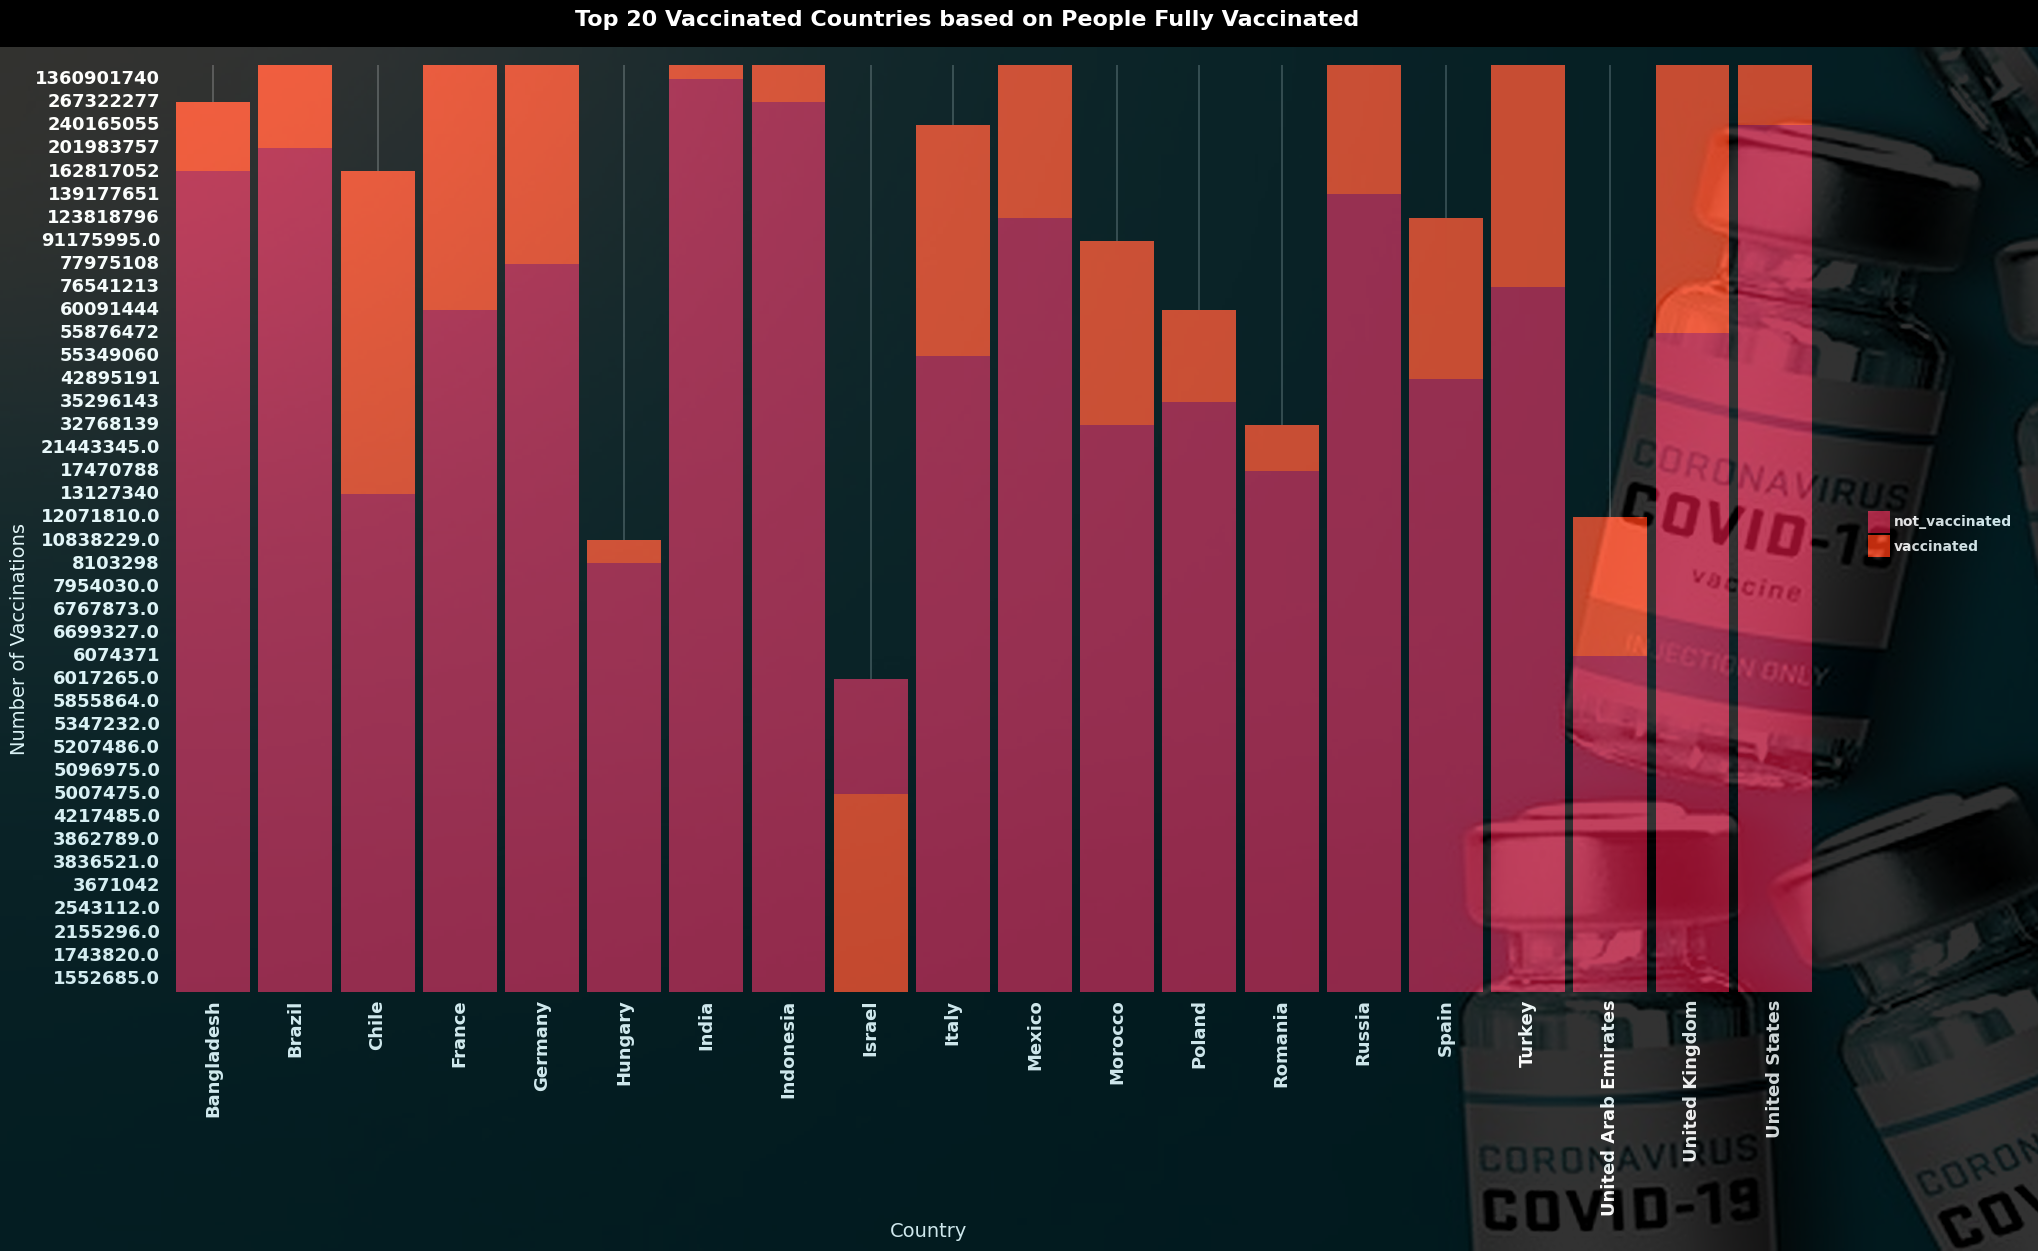

In [13]:
top_20_countries_people_fully_vaccinated = pd.DataFrame(vaccination_data.groupby("country")["people_fully_vaccinated"].max().sort_values(ascending = False).head(20))
top_20_countries_people_fully_vaccinated.reset_index(level=0,inplace=True)
top_20_countries_people_fully_vaccinated = convert_df_with_continent(top_20_countries_people_fully_vaccinated)
top_20_countries_people_fully_vaccinated = population_agg(top_20_countries_people_fully_vaccinated)
top_20_countries_people_fully_vaccinated = stack_population_df_fully_vaccinated(top_20_countries_people_fully_vaccinated)


op.figure_size=(8,10)
ax = (ggplot(top_20_countries_people_fully_vaccinated)         
 + aes(x='country', y='total_vaccinations',fill='vaccination_status')    
 + geom_col(size=20)
 + scale_fill_manual(values = ["#B21236","#F03812","#FE8826","#FEB914","#2C9FA2","#002C2B","#F7E1C0"])
 + labs(title = "Top 20 Vaccinated Countries based on People Fully Vaccinated")
 + labs(y = "Number of Vaccinations", x = "Country")
 + theme(
    panel_background = element_rect(fill = "black"),    
    plot_background = element_rect(fill = "black", color = "black"),
    legend_background = element_rect(fill = "black"),
    legend_key = element_blank(),
   
    panel_grid = element_line(size = 0.3),
    panel_grid_minor_y = element_blank(),
    panel_grid_major_y = element_blank(),
    
    legend_text = element_text(color = "white",size = 10,face = "bold"),
    axis_text_x = element_text(color = "white", size = 13,angle=90,face = "bold"),
    axis_text_y = element_text(color = "white", size = 13, hjust = 1, margin={'b': 20, 't':10},face = "bold"),
    axis_title = element_text(color = "white", size = 14, hjust = 1),
    plot_title = element_text(color = "white", face = "bold", size = 16, hjust = 4, margin={'b': 20, 't':10}),
    panel_spacing_x = 1
  )
)

fig = ax.draw()

image = plt.imread('https://raw.githubusercontent.com/vineethbabu/coronavaccine_images/main/11_enlargev1.png')

fig.figimage(image, xo=0, yo=0, alpha=0.2, norm=None, cmap=None, vmin=None, vmax=None, origin=None, resize=True)

fig.show()

We can clearly see that all of these counties still have a lot of not vaccinated population.It is clearly evident from this plot specially for heavily populated county like India.

**Israel stands out as the country that has more vaccinated than not vaccinated.**

# **Top 20 Vaccinated Countries based on People Fully Vacccinated per Hundred**

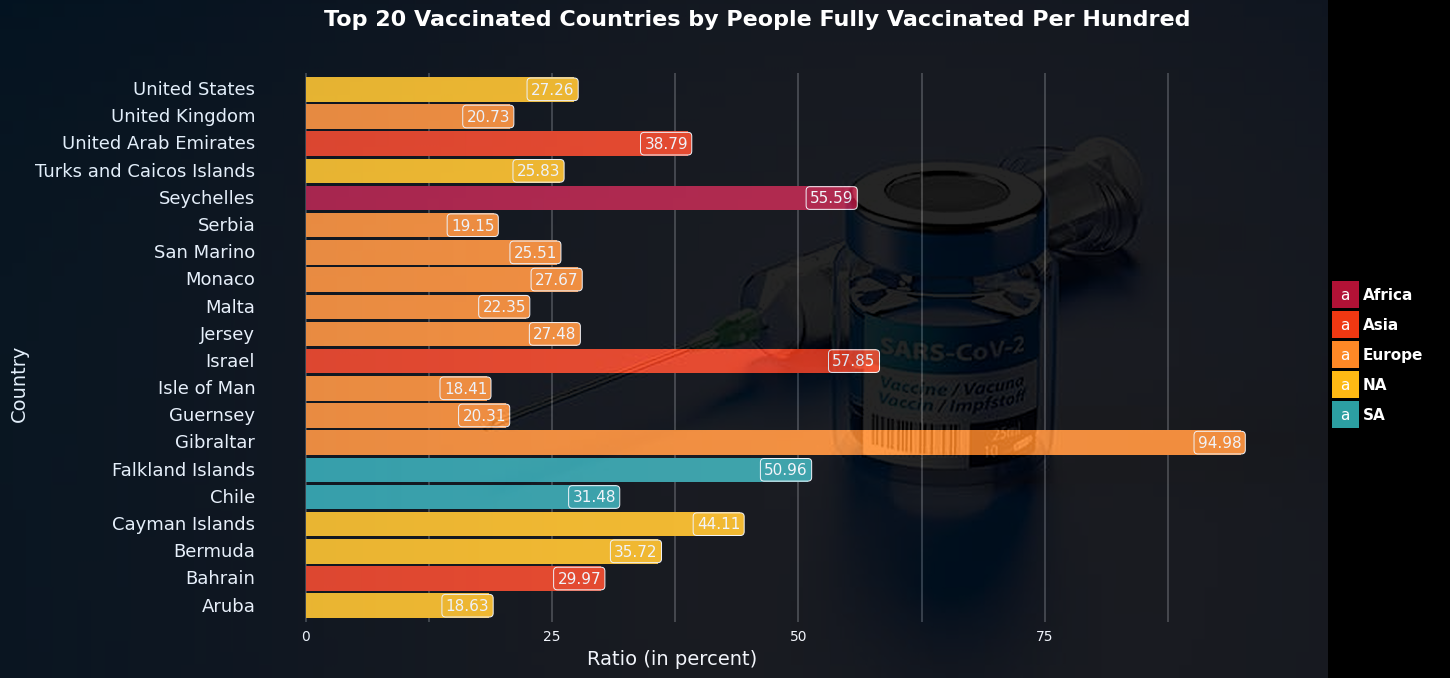

In [14]:
top_20_countries_pfvph = pd.DataFrame(vaccination_data.groupby("country")["people_fully_vaccinated_per_hundred"].max().sort_values(ascending = False).head(20))
top_20_countries_pfvph.reset_index(level=0,inplace=True)
top_20_countries_pfvph = convert_df_with_continent(top_20_countries_pfvph)

top_20_countries_pfvph['number_labels'] = ['']*top_20_countries_pfvph.shape[0]

for i in range(top_20_countries_pfvph.shape[0]):
    top_20_countries_pfvph['number_labels'].iloc[i] = format_number(top_20_countries_pfvph['people_fully_vaccinated_per_hundred'].iloc[i])
op.figure_size=(5,5)
ax = (ggplot(top_20_countries_pfvph)         
 + aes(x='country', y='people_fully_vaccinated_per_hundred',fill='continent')    
 + geom_col(size=13)
 + geom_label(aes(label = 'number_labels'),ha='right',color = "white",label_padding= 0.25)
 + coord_flip()
 + scale_fill_manual(values = ["#B21236","#F03812","#FE8826","#FEB914","#2C9FA2","#002C2B","#F7E1C0"])
 + labs(title = "Top 20 Vaccinated Countries by People Fully Vaccinated Per Hundred")
 + labs(y = "Ratio (in percent)", x = "Country")
 + theme(
    panel_background = element_rect(fill = "black"),    
    plot_background = element_rect(fill = "black", color = "black"),
    legend_background = element_rect(fill = "black"),
    legend_key = element_blank(),
   
    panel_grid = element_line(size = 0.3),
    panel_grid_minor_y = element_blank(),
    panel_grid_major_y = element_blank(),
    
    legend_text = element_text(color = "white",size=11,face='bold'),
    axis_text_x = element_text(color = "white", size = 10),
    axis_text_y = element_text(color = "white", size = 13, hjust = 1, margin={'b': 20, 't':10}),
    axis_title = element_text(color = "white", size = 14, hjust = 1),
    plot_title = element_text(color = "white", face = "bold", size = 16, hjust = 4, margin={'b': 20, 't':10}),
    panel_spacing_x = 1
  )
)

fig = ax.draw()

image = plt.imread('https://raw.githubusercontent.com/vineethbabu/coronavaccine_images/main/12.png')

fig.figimage(image, xo=0, yo=0, alpha=0.15, norm=None, cmap=None, vmin=None, vmax=None, origin=None, resize=True)

fig.show()

In top countries with people fully vaccinated per hundred we have 
   * **Gibraltar** - Europe
   * **Israel** - Asia
   * **Seychelles** - Africa
   * **Falkland Islands** - South America
   * **Cayman Islands** - North America

**Gibraltar** has vaccinated almost all of its adult population. <br>
More than half of the population is vaccinated in **Israel**, **Seychelles** and **Falkland Islands**.

# **Total Vaccinations of each Vaccine**

In [15]:
vaccine_manufacture = pd.read_csv('../input/covid-world-vaccination-progress/country_vaccinations_by_manufacturer.csv')

vaccine_counts = pd.DataFrame(vaccine_manufacture.groupby("vaccine")["total_vaccinations"].max().sort_values(ascending = False))
vaccine_counts.reset_index(level=0,inplace=True)

vaccine_counts['number_labels'] = ['']*vaccine_counts.shape[0]

for i in range(vaccine_counts.shape[0]):
    vaccine_counts['number_labels'].iloc[i] = format_number(vaccine_counts['total_vaccinations'].iloc[i])
    

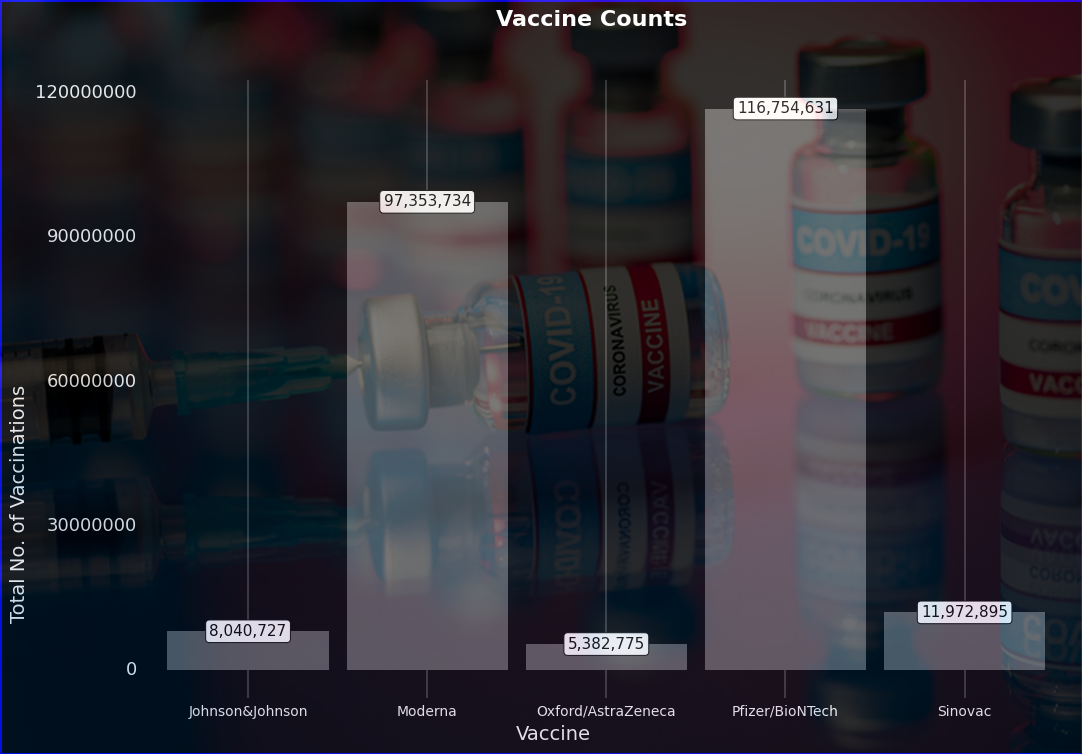

In [16]:
op.figure_size=(8,5)
ax = (ggplot(vaccine_counts)         
 + aes(x='vaccine', y='total_vaccinations')    
 + geom_col(size=15)
 + geom_label(aes(label = 'number_labels'),ha='center',color = "black",label_padding= 0.25)
 + scale_fill_manual(values = ["#B21236","#F03812","#FE8826","#FEB914","#2C9FA2","#002C2B","#F7E1C0"])
 + labs(title = "Vaccine Counts")
 + labs(y = "Total No. of Vaccinations", x = "Vaccine")
 + theme(
    panel_background = element_rect(fill = "black"),    
    plot_background = element_rect(fill = "black", color = "blue"),
    legend_background = element_rect(fill = "black"),
    legend_key = element_blank(),
   
    panel_grid = element_line(size = 0.3),
    panel_grid_minor_y = element_blank(),
    panel_grid_major_y = element_blank(),
    
    legend_text = element_text(color = "white"),
    axis_text_x = element_text(color = "white", size = 10),
    axis_text_y = element_text(color = "white", size = 13, hjust = 1, margin={'b': 20, 't':10}),
    axis_title = element_text(color = "white", size = 14, hjust = 1),
    plot_title = element_text(color = "white", face = "bold", size = 16, hjust = 4, margin={'b': 20, 't':10}),
    panel_spacing_x = 1
  )
)

fig = ax.draw()

image = plt.imread('https://raw.githubusercontent.com/vineethbabu/coronavaccine_images/main/4.png')

fig.figimage(image, xo=0, yo=0, alpha=0.2, norm=None, cmap=None, vmin=None, vmax=None, origin=None, resize=True)

fig.show()

The total number of vaccinations of each vaccine are:
   * **Pfizer/BioNTech** - 116.7 M
   * **Moderna** - 97.3 M
   * **Sinovac** - 11.9 M
   * **Oxford/AstraZeneca** - 5.3 M
   * **Johnson&Jonson** - 8.0 M 

# **Top 50 Highest Vaccinated Countries Count in each Continent**

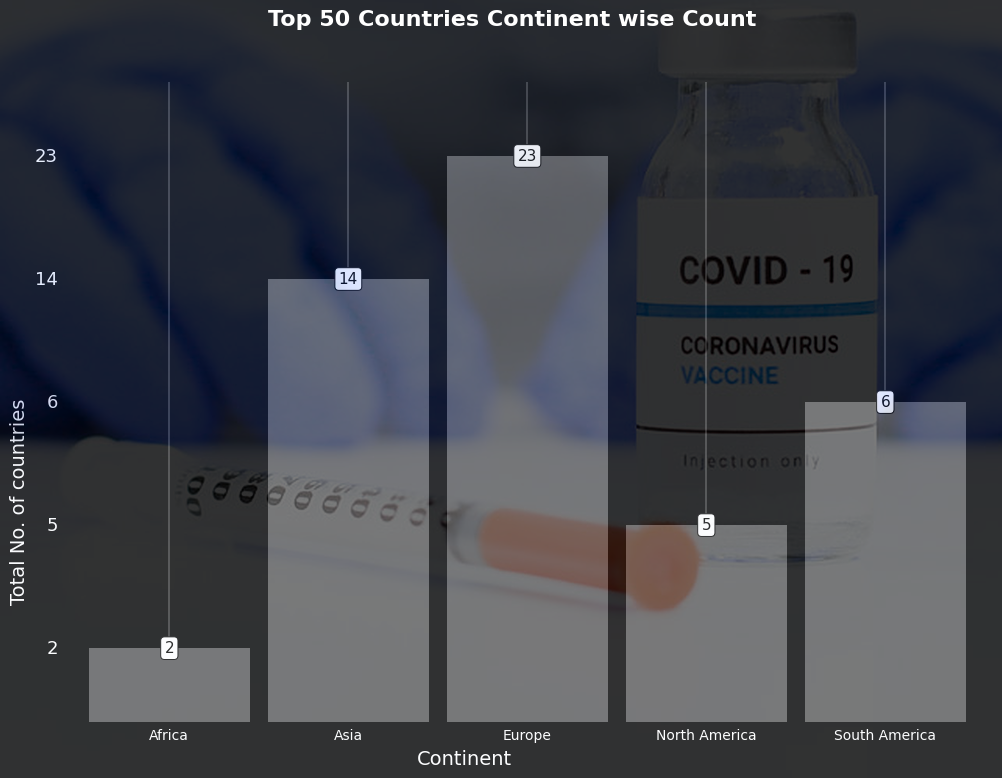

In [17]:
top_50_countries_people_fully_vaccinated = pd.DataFrame(vaccination_data.groupby("country")["people_fully_vaccinated"].max().sort_values(ascending = False).head(50))
top_50_countries_people_fully_vaccinated.reset_index(level=0,inplace=True)
top_50_countries_people_fully_vaccinated = convert_df_with_continent(top_50_countries_people_fully_vaccinated)
top50_countries_continent_count = pd.DataFrame(top_50_countries_people_fully_vaccinated.groupby('continent')['country'].apply(list))
top50_countries_continent_count['country_count'] = ['']*top50_countries_continent_count.shape[0]
top50_countries_continent_count.reset_index(level=0,inplace=True)

for i in range(top50_countries_continent_count.shape[0]):
    top50_countries_continent_count['country_count'].iloc[i] = len(top50_countries_continent_count['country'].iloc[i])
    if top50_countries_continent_count['continent'].iloc[i] == 'NA':
        top50_countries_continent_count['continent'].iloc[i] = 'North America'
    elif top50_countries_continent_count['continent'].iloc[i] == 'SA':
        top50_countries_continent_count['continent'].iloc[i] = 'South America'

op.figure_size=(8,5)
ax = (ggplot(top50_countries_continent_count)         
 + aes(x='continent', y='country_count')    
 + geom_col(size=15)
 + geom_label(aes(label = 'country_count'),ha='center',color = "black",label_padding= 0.25)
 + scale_fill_manual(values = ["#B21236","#F03812","#FE8826","#FEB914","#2C9FA2","#002C2B","#F7E1C0"])
 + labs(title = "Top 50 Countries Continent wise Count")
 + labs(y = "Total No. of countries", x = "Continent")
 + theme(
    panel_background = element_rect(fill = "black"),    
    plot_background = element_rect(fill = "black", color = "black"),
    legend_background = element_rect(fill = "black"),
    legend_key = element_blank(),
   
    panel_grid = element_line(size = 0.3),
    panel_grid_minor_y = element_blank(),
    panel_grid_major_y = element_blank(),
    
    legend_text = element_text(color = "white"),
    axis_text_x = element_text(color = "white", size = 10),
    axis_text_y = element_text(color = "white", size = 13, hjust = 1, margin={'b': 20, 't':10}),
    axis_title = element_text(color = "white", size = 14, hjust = 1),
    plot_title = element_text(color = "white", face = "bold", size = 16, hjust = 4, margin={'b': 20, 't':10}),
    panel_spacing_x = 1
  )
)

fig = ax.draw()

image = plt.imread('https://raw.githubusercontent.com/vineethbabu/coronavaccine_images/main/7.png')

fig.figimage(image, xo=0, yo=0, alpha=0.2, norm=None, cmap=None, vmin=None, vmax=None, origin=None, resize=True)

fig.show()

Top 50 countries continent wise count:
> **23 European**, 
> **14 Asian**, 
> **6 South American**, 
> **5 North America**, 
> **2 African countries**.   

# **Least Fully Vaccinated People Per Hundred Country in a Continent**

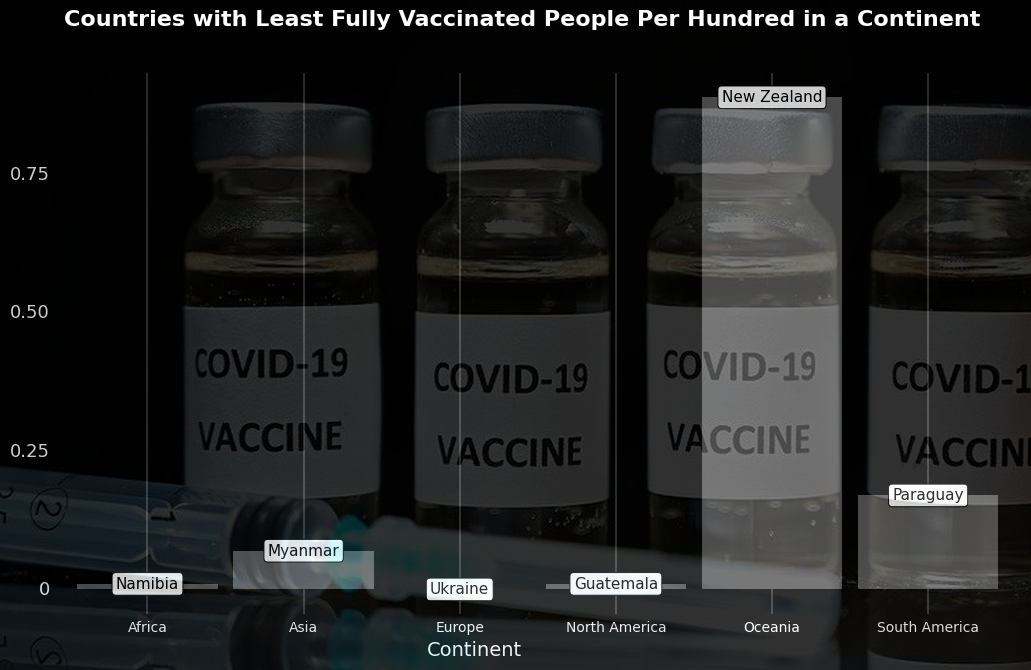

In [18]:
countries_pfvph = pd.DataFrame(vaccination_data.groupby("country")["people_fully_vaccinated_per_hundred"].max().sort_values(ascending = False))
countries_pfvph.reset_index(level=0,inplace=True)
countries_pfvph = convert_df_with_continent(countries_pfvph)
# bottom_20_countries_pfvph.groupby('continent', as_index=False).apply(lambda x: x.loc[x.people_fully_vaccinated_per_hundred.argmin(),])
bottom_20_countries_pfvph = pd.DataFrame(countries_pfvph.groupby("continent")["people_fully_vaccinated_per_hundred"].min())
bottom_20_countries_pfvph['country'] = ['']*bottom_20_countries_pfvph.shape[0]
bottom_20_countries_pfvph.reset_index(level=0,inplace=True)
for i in range(bottom_20_countries_pfvph.shape[0]):
    pvfh = bottom_20_countries_pfvph['people_fully_vaccinated_per_hundred'].iloc[i]
    continent = bottom_20_countries_pfvph['continent'].iloc[i]
    bottom_20_countries_pfvph['country'].iloc[i] = countries_pfvph.loc[(countries_pfvph['people_fully_vaccinated_per_hundred']==pvfh) & (countries_pfvph['continent']==continent)]['country'].values[0]
    if bottom_20_countries_pfvph['continent'].iloc[i] == 'NA':
        bottom_20_countries_pfvph['continent'].iloc[i] = 'North America'
    elif bottom_20_countries_pfvph['continent'].iloc[i] == 'SA':
        bottom_20_countries_pfvph['continent'].iloc[i] = 'South America'
op.figure_size=(8,5)
ax = (ggplot(bottom_20_countries_pfvph)         
 + aes(x='continent', y='people_fully_vaccinated_per_hundred')    
 + geom_col(size=15)
 + geom_label(aes(label = 'country'),ha='center',color = "black",label_padding= 0.25)
 + scale_fill_manual(values = ["#B21236","#F03812","#FE8826","#FEB914","#2C9FA2","#002C2B","#F7E1C0"])
 + labs(title = "Countries with Least Fully Vaccinated People Per Hundred in a Continent")
 + labs(y = "", x = "Continent")
 + theme(
    panel_background = element_rect(fill = "black"),    
    plot_background = element_rect(fill = "black", color = "black"),
    legend_background = element_rect(fill = "black"),
    legend_key = element_blank(),
   
    panel_grid = element_line(size = 0.3),
    panel_grid_minor_y = element_blank(),
    panel_grid_major_y = element_blank(),
    
    legend_text = element_text(color = "white"),
    axis_text_x = element_text(color = "white", size = 10),
    axis_text_y = element_text(color = "white", size = 13, hjust = 1, margin={'b': 20, 't':10}),
    axis_title = element_text(color = "white", size = 14, hjust = 1),
    plot_title = element_text(color = "white", face = "bold", size = 16, hjust = 4, margin={'b': 20, 't':10}),
    panel_spacing_x = 1
  )
)

fig = ax.draw()

image = plt.imread('https://raw.githubusercontent.com/vineethbabu/coronavaccine_images/main/9.png')

fig.figimage(image, xo=0, yo=0, alpha=0.2, norm=None, cmap=None, vmin=None, vmax=None, origin=None, resize=True)

fig.show()

Continent wise countries with least fully vaccinated people: 
> * **Namibia** in Africa - **0.01**
> * **Ukraine** in Europe - **0.00**
> * **Mynmar** in Asia - **0.07**
> * **Guatemala** in North America - **0.01**
> * **Paraguay** in South America - **0.17**

<center><h2><b>Thanks For Reading</b></h2></center>
<center><b>Please give your Suggestion and Comments.</b></center>